In [ ]:
import json
from core.signals import OECDUSLEIHP
from core.strategies import BacktestManager

signal = OECDUSLEIHP.from_fred_data()

def get_universe(name: str = "USSECTOR"):
    with open("universe.json") as f:
        return json.load(f).get(name)
    
from core import data

prices = data.get_prices(tickers = list(get_universe().keys()))
bt = BacktestManager(prices=prices, start="2007-1-1", commission=10, shares_frac=0)
bt.Base(objective="minimized_volatility")
bt.Base(objective="uniform_allocation")
bt.Signal(objective="minimized_volatility", signal=signal)


,Base(objective=minimized_volatility),Base(objective=uniform_allocation),Signal(objective=minimized_volatility&signal=OECDUSLEIHP),Signal(objective=minimized_volatility&regime_window=1512&signal=OECDUSLEIHP),Signal(objective=minimized_volatility&regime_window=12600&signal=OECDUSLEIHP)
Start,2007-01-03,2007-01-03,2007-01-03,2007-01-03,2007-01-03
End,2023-05-26,2023-05-26,2023-05-26,2023-05-26,2023-05-26
AnnReturn,0.093196,0.102725,0.115825,0.109522,0.12171
AnnVolatility,0.154555,0.196644,0.191484,0.18725,0.193699
SharpeRatio,0.602996,0.522392,0.604881,0.584897,0.628344
SortinoRatio,0.736674,0.630068,0.737325,0.724721,0.766386
CalmarRatio,0.243816,0.193069,0.233737,0.234981,0.245612
TailRatio,0.243825,0.201788,0.172281,0.196014,0.171134
JensensAlpha,-0.786599,-0.9816,-1.125127,-1.045115,-1.198296
TreynorRatio,0.082014,0.102345,0.11731,0.108967,0.124939


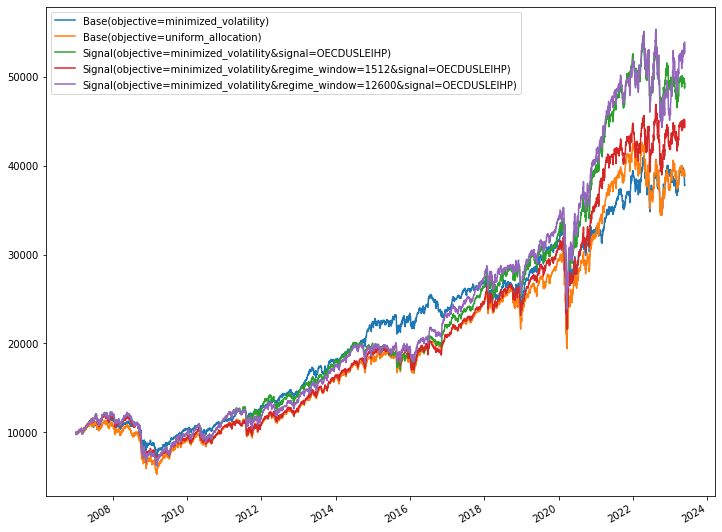

In [4]:
bt.Signal(objective="minimized_volatility", signal=signal, regime_window=50*252)

bt.values.plot(figsize=(12, 10))
bt.analytics

In [ ]:
from core import metrics

metrics.to_hurst_exponent(prices=prices.iloc[-100:])

In [ ]:
prices.XLI.iloc[-50:].plot()

In [ ]:
metrics.to_momentum(prices, months=1)

In [ ]:
bt.strategies["Momentum(months=1&target_percentile=0.5)"].allocations.loc["2022"]

In [ ]:
from core import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = {
    "T5YIE": "Breakeven Inflation: 5Y",
    "T10YIE": "Breakeven Inflation: 10Y",
    "T5YIFR": "Expectation Infaltiona: 5Y",
}

result = data.get_macro(tickers=tickers).dropna()
result["chg"] = result["Breakeven Inflation: 10Y"] - result["Breakeven Inflation: 5Y"]
spy = data.get_prices(tickers="SPY")

# Create a line plot for each series
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(
    go.Scatter(x=spy.index, y=spy["SPY"], mode="lines", name="SPY"), row=1, col=1
)
for series in result:
    fig.add_trace(
        go.Scatter(x=result.index, y=result[series], mode="lines", name=series),
        row=2,
        col=1,
    )

# Set the title and axis labels
fig.update_layout(title="Inflation", xaxis_title="Date", yaxis_title="%", height=600)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=False),
        type="date",
    ),
    hovermode="x unified",  # Enable the "Show All Stats" option on mouseover
)

# Display the graph
fig.show()

In [ ]:
from core.strategies import BacktestManager
bt = BacktestManager.from_universe(start="2010-1-1", commission=10, shares_frac=0)
bt.Momentum()
bt.values.plot()
